In [4]:
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as torch_models
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from PIL import Image
from torch.autograd import Variable
from numpy import linalg
import math
from math import cos, sqrt, pi
import time
import copy
import csv
import pandas as pd
from tqdm import tqdm
from torchvision.models import ResNet50_Weights

## Getting Data

#### Download Image Net

In [46]:
!wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar

2502.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


--2024-03-10 16:07:03--  https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6744924160 (6,3G) [application/x-tar]
Saving to: ‘ILSVRC2012_img_val.tar’

ILSVRC2012_img_val. 100%[===================>]   6,28G  4,42MB/s    in 23m 14s 

2024-03-10 16:30:18 (4,61 MB/s) - ‘ILSVRC2012_img_val.tar’ saved [6744924160/6744924160]



In [87]:
!mkdir ./ILSVRC2012_img_val
!tar -xf ILSVRC2012_img_val.tar -C ./ILSVRC2012_img_val

10072.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
10077.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


### Download Flowers 102

In [68]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

7761.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


--2024-03-10 17:34:42--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2024-03-10 17:34:45--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328,89M  14,7MB/s    in 24s     

2024-03-10 17:35:10 (13,6 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [88]:
!mkdir ./Flowers102
!tar -xf 102flowers.tgz -C ./Flowers102

10139.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
10144.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


### Get images to experiment

In [47]:
from collections import defaultdict
import random

In [76]:
def get_random_images(input_txt_path, output_csv_path):
    # Lendo o arquivo TXT
    df = pd.read_csv(input_txt_path, sep=' ', header=None, names=['image_name', 'class'])

    # Criando um dicionário para armazenar as imagens por classe
    images_per_class = defaultdict(list)
    for index, row in df.iterrows():
        images_per_class[row['class']].append(row['image_name'])

    # Embaralhando as chaves das classes para seleção aleatória
    classes = list(images_per_class.keys())
    random.shuffle(classes)

    # Inicializando a lista para armazenar as imagens selecionadas e suas classes
    selected_images_and_classes = []

    for i in range(TOTAL_IMAGES_TO_USE):
        class_id = classes[i % len(classes)]
        image_name = images_per_class[class_id][i % len(images_per_class[class_id])]
        selected_images_and_classes.append((image_name, class_id))

    # Criando um DataFrame com as imagens selecionadas e suas classes
    df_selected = pd.DataFrame(selected_images_and_classes, columns=['image_name', 'class'])

    # Salvando o DataFrame em um arquivo CSV
    df_selected.to_csv(output_csv_path, index=False)

    print(f"Arquivo '{output_csv_path}' salvo com sucesso.")
    print(f"Total de imagens selecionadas: {len(df_selected)}")
    print(f"Total de classes cobertas: {df_selected['class'].nunique()}")

    # Retornando o DataFrame para visualização
    return df_selected


In [95]:
TOTAL_IMAGES_TO_USE = 175

In [103]:
# Image Net
df_image_net = get_random_images('val.txt', 'val_used_imagens.csv')

Arquivo 'val_used_imagens.csv' salvo com sucesso.
Total de imagens selecionadas: 175
Total de classes cobertas: 175


In [104]:
df_image_net.groupby('class').size().reset_index(name='counts').sort_values('counts', ascending=False)

,class,counts
0,2,1
120,682,1
112,627,1
113,629,1
114,630,1
...,...,...
60,396,1
61,397,1
62,398,1
63,399,1


In [105]:
# Flowers 102
df_flowers = get_random_images('val_102flowers.txt', 'val_flowers_used_imagens.csv')

Arquivo 'val_flowers_used_imagens.csv' salvo com sucesso.
Total de imagens selecionadas: 175
Total de classes cobertas: 102


In [106]:
df_flowers.groupby('class').size().reset_index(name='counts').sort_values('counts', ascending=False)

,class,counts
0,1,2
61,62,2
69,70,2
68,69,2
67,68,2
...,...,...
54,55,1
15,16,1
53,54,1
81,82,1


### Load images into /data

In [89]:
import shutil

In [90]:
def move_images(csv_file_path, source_directory, target_directory):
    # Lendo o arquivo CSV para obter os nomes das imagens
    df = pd.read_csv(csv_file_path)

    # Iterando sobre os nomes das imagens no DataFrame
    for image_name in df['image_name']:
        source_path = os.path.join(source_directory, image_name)
        target_path = os.path.join(target_directory, image_name)

        # Movendo a imagem
        try:
            shutil.move(source_path, target_path)
        except FileNotFoundError:
            print(f"Imagem {image_name} não encontrada em {source_directory}.")
        except Exception as e:
            print(f"Erro ao mover {image_name}: {e}")


In [92]:
# Image net
# ONLY RUN THIS CODE ONE TIME
!mkdir ./data/ILSVRC2012_img_val
# move_images('val_used_imagens.csv', './ILSVRC2012_img_val', './data/ILSVRC2012_img_val')

10237.37s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [93]:
# Flowers 102
# ONLY RUN THIS CODE ONE TIME
!mkdir ./data/Flowers102
# move_images('val_flowers_used_imagens.csv', './Flowers102/jpg', './data/Flowers102')

10260.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## Functions

In [5]:
def dct(x, y, v, u, n):
    # Normalisation
    def alpha(a):
        if a == 0:
            return sqrt(1.0 / n)
        else:
            return sqrt(2.0 / n)

    return alpha(u) * alpha(v) * cos(((2 * x + 1) * (u * pi)) / (2 * n)) * cos(((2 * y + 1) * (v * pi)) / (2 * n))


def generate_2d_dct_basis(sub_dim=75):
    n = 224  # Assume square image, so we don't have different xres and yres

    # We can get different frequencies by setting u and v
    # Here, we have a max u and v to loop over and display
    # Feel free to adjust
    maxU = sub_dim
    maxV = sub_dim

    dct_basis = []
    for u in range(0, maxU):
        for v in range(0, maxV):
            basisImg = np.zeros((n, n))
            for y in range(0, n):
                for x in range(0, n):
                    basisImg[y, x] = dct(x, y, v, u, max(n, maxV))
            dct_basis.append(basisImg)
    dct_basis = np.mat(np.reshape(dct_basis, (maxV*maxU, n*n))).transpose()
    np.save('2d_dct_basis_{}.npy'.format(sub_dim), dct_basis)
    return dct_basis


In [6]:
def get_label(x):
    s = x.split(' ')
    label = ''
    for l in range(1, len(s)):
        label += s[l] + ' '

    return label

def clip_image_values(x, minv, maxv):
    x = torch.max(x, minv)
    x = torch.min(x, maxv)
    return x


def valid_bounds(img, delta=255):

    im = copy.deepcopy(np.asarray(img))
    im = im.astype(int)

    # General valid bounds [0, 255]
    valid_lb = np.zeros_like(im)
    valid_ub = np.full_like(im, 255)

    # Compute the bounds
    lb = im - delta
    ub = im + delta

    # Validate that the bounds are in [0, 255]
    lb = np.maximum(valid_lb, np.minimum(lb, im))
    ub = np.minimum(valid_ub, np.maximum(ub, im))

    # Change types to uint8
    lb = lb.astype(np.uint8)
    ub = ub.astype(np.uint8)

    return lb, ub

In [7]:
torch.manual_seed(992)
torch.cuda.manual_seed(992)
np.random.seed(992)

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [9]:
def inv_tf(x, mean, std):
    x_clone = x.copy()

    for i in range(len(mean)):

        x_clone[i] = np.multiply(x_clone[i], std[i], dtype=np.float32)
        x_clone[i] = np.add(x_clone[i], mean[i], dtype=np.float32)

    x_clone = np.swapaxes(x_clone, 0, 2)
    x_clone = np.swapaxes(x_clone, 0, 1)

    return x_clone

In [10]:
def is_adversarial(target_model, given_image, orig_label):

    predict_label = torch.argmax(target_model.forward(Variable(given_image, requires_grad=True)).data).item()

    return predict_label != orig_label

In [11]:
def find_random_adversarial(target_model, orig_label, image, lb, ub):

    num_calls = 1

    step = 0.02
    perturbed = image.clone()

    while is_adversarial(target_model, perturbed, orig_label) == 0:

        pert = torch.randn([1,3,224,224])
        pert = pert.to(device)

        perturbed = image + num_calls*step* pert
        perturbed = clip_image_values(perturbed, lb, ub)
        perturbed = perturbed.to(device)
        num_calls += 1

    return perturbed, num_calls

In [12]:
def bin_search(target_model, orig_label, x_0, x_random, tol):

    num_calls = 0
    adv = x_random
    cln = x_0

    while True:

        mid = (cln + adv) / 2.0
        num_calls += 1

        if is_adversarial(target_model, mid, orig_label):
            adv = mid
        else:
            cln = mid

        if torch.norm(adv-cln).cpu().numpy()<tol:
            break

    return adv, num_calls

In [13]:
def black_grad_batch(target_model, x_boundary, q_max, sigma, random_noises, batch_size, original_label, sub_basis_torch):

    grad_tmp = [] # estimated gradients in each estimate_batch
    z = []        # sign of grad_tmp
    outs = []
    num_batchs = math.ceil(q_max/batch_size)
    last_batch = q_max - (num_batchs-1)*batch_size
    
    if torch.cuda.is_available():
        EstNoise = SubNoise(batch_size, sub_basis_torch).cuda()
    else:
        EstNoise = SubNoise(batch_size, sub_basis_torch)

    all_noises = []
    for j in range(num_batchs):
        if j == num_batchs-1:
            if torch.cuda.is_available():
                EstNoise_last = SubNoise(last_batch, sub_basis_torch).cuda()
            else:
                EstNoise_last = SubNoise(last_batch, sub_basis_torch)

            current_batch = EstNoise_last()
            current_batch_np = current_batch.cpu().numpy()
            noisy_boundary = [x_boundary[0,:,:,:].cpu().numpy()]*last_batch +sigma*current_batch.cpu().numpy()

        else:
            current_batch = EstNoise()
            current_batch_np = current_batch.cpu().numpy()
            noisy_boundary = [x_boundary[0,:,:,:].cpu().numpy()]*batch_size +sigma*current_batch.cpu().numpy()

        all_noises.append(current_batch_np)

        noisy_boundary_tensor = torch.tensor(noisy_boundary).to(device)

        predict_labels = torch.argmax(target_model.forward(noisy_boundary_tensor),1).cpu().numpy().astype(int)


        outs.append(predict_labels)
    all_noise = np.concatenate(all_noises, axis=0)
    outs = np.concatenate(outs, axis=0)

    acc = np.mean(outs == original_label)
    for i, predict_label in enumerate(outs):
        if predict_label == original_label:
            z.append(1)
            grad_tmp.append(all_noise[i])
        else:
            z.append(-1)
            grad_tmp.append(-all_noise[i])

    grad = -(1/q_max)*sum(grad_tmp)

    grad_f = torch.tensor(grad).to(device)[None, :,:,:]

    return grad_f, sum(z), acc

In [14]:
def go_to_boundary(target_model, orig_label, x_0, grad, x_b, dist, lb, ub):

    epsilon = 5

    num_calls = 1
    perturbed = x_0

    if dist == 'l1' or dist == 'l2':

        grads = grad


    if dist == 'linf':

        grads = torch.sign(grad)/torch.norm(grad)



    while is_adversarial(target_model, perturbed, orig_label) == 0:

        perturbed = x_0 + (num_calls*epsilon* grads[0])
        perturbed = clip_image_values(perturbed, lb, ub)

        num_calls += 1

        if num_calls > 100:
            print('falied ... ')
            break
        print
    return perturbed, num_calls, epsilon*num_calls

In [15]:
def load_sub_basis(search_space, sub_dim=75, verbose_control='Yes'):
  if search_space == 'sub':

    if verbose_control == 'Yes':
      print('Check if DCT basis available ...')

    path = './2d_dct_basis_{}.npy'.format(sub_dim)
    if os.path.exists(path):
        if verbose_control == 'Yes':
          print('Yes, we already have it ...')
        sub_basis = np.load('2d_dct_basis_{}.npy'.format(sub_dim)).astype(np.float32)
    else:
        print('Generating dct basis ......')
        sub_basis = generate_2d_dct_basis(sub_dim).astype(np.float32)
        print('Done!\n')

    if torch.cuda.is_available():
      sub_basis_torch = torch.from_numpy(sub_basis).cuda()
    else:
      sub_basis_torch = torch.from_numpy(sub_basis)

    return sub_basis_torch

In [16]:
def GeoDA(target_model, x_b, x_0, iteration, q_opt, dist, image_fb, orig_label, lb, ub, grad_estimator_batch_size=40, verbose_control='Yes', sigma=0.0002, tol=0.0001, search_space='sub', q_max=None, image_name=None):

    # Load sub basis
    sub_basis_torch = load_sub_basis(search_space, verbose_control=verbose_control)

    iteration_data = []  # List to store iteration data
    q_num = 0
    grad = 0

    for i in range(iteration):

        t1 = time.time()
        random_vec_o = torch.randn(q_opt[i],3,224,224)

        grad_oi, ratios, acc = black_grad_batch(target_model, x_b, q_opt[i], sigma, random_vec_o, grad_estimator_batch_size , orig_label, sub_basis_torch)
        q_num = q_num + q_opt[i]
        grad = grad_oi + grad
        x_adv, qs, eps = go_to_boundary(target_model, orig_label, x_0, grad, x_b, dist, lb, ub)
        q_num = q_num + qs
        x_adv, bin_query = bin_search(target_model, orig_label, x_0, x_adv, tol)


        q_num = q_num + bin_query

        x_b = x_adv

        t2 = time.time()
        x_adv_inv = inv_tf(x_adv.cpu().numpy()[0,:,:,:].squeeze(), mean, std)

        if dist == 'l1' or dist == 'l2':
            dp = 'l2'
            norm_p = linalg.norm(x_adv_inv-image_fb)


        if dist == 'linf':
            dp = dist

            norm_p = np.max(abs(x_adv_inv-image_fb))

        adv_label = torch.argmax(target_model.forward(Variable(x_adv, requires_grad=True)).data).item()
        iteration_data.append(('geoda', i, dist, search_space, norm_p, t2 - t1, q_num, q_max, image_name, orig_label, adv_label, acc))

        if verbose_control == 'Yes':
            message = ' (took {:.5f} seconds)'.format(t2 - t1)
            print('iteration -> ' + str(i) + str(message) + '     -- ' + dp + ' norm is -> ' + str(norm_p))

    with open('log.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['attack', 'iteration', 'distance', 'space', 'norm_p', 'time', 'query_num', 'query_max', 'image', 'orig_label', 'adv_label', 'acc'])  # Remova esta linha se o cabeçalho já existir
        writer.writerows(iteration_data)


    x_adv = clip_image_values(x_adv, lb, ub)

    return x_adv, q_num, grad

In [17]:
def opt_query_iteration(Nq, T, eta):

    coefs=[eta**(-2*i/3) for i in range(0,T)]
    coefs[0] = 1*coefs[0]

    sum_coefs = sum(coefs)
    opt_q=[round(Nq*coefs[i]/sum_coefs) for i in range(0,T)]

    if opt_q[0]>80:
        T = T + 1
        opt_q, T = opt_query_iteration(Nq, T, eta)
    elif opt_q[0]<50:
        T = T - 1

        opt_q, T = opt_query_iteration(Nq, T, eta)

    return opt_q, T

def uni_query(Nq, T, eta):

    opt_q=[round(Nq/T) for i in range(0,T)]


    return opt_q

In [18]:
def load_image(image, shape=(224, 224), data_format='channels_last'):

    assert len(shape) == 2
    assert data_format in ['channels_first', 'channels_last']

    image = image.resize(shape)
    image = np.asarray(image, dtype=np.float32)

    image = image[:, :, :3]
    assert image.shape == shape + (3,)
    if data_format == 'channels_first':
        image = np.transpose(image, (2, 0, 1))
    return image

In [19]:
class SubNoise(nn.Module):
    """given subspace x and the number of noises, generate sub noises"""
    # x is the subspace basis
    def __init__(self, num_noises, x):
        self.num_noises = num_noises
        self.x = x
        super(SubNoise, self).__init__()

    def forward(self):


        r = torch.zeros([224 ** 2, 3*self.num_noises], dtype=torch.float32)
        if torch.cuda.is_available():
            noise = torch.randn([self.x.shape[1], 3*self.num_noises], dtype=torch.float32).cuda()
        else:
            noise = torch.randn([self.x.shape[1], 3*self.num_noises], dtype=torch.float32)
            
        sub_noise = torch.transpose(torch.mm(self.x, noise), 0, 1)
        r = sub_noise.view([ self.num_noises, 3, 224, 224])

        r_list = r
        return r_list

## GeoDA

In [20]:
def run_geoDa(target_model, image_path, true_label, Q_max=1000, dist='l2', tol=0.0001, mu=0.6, search_space='sub', grad_estimator_batch_size=40, verbose_control='Yes'):

  # Load image and tested
  im_orig = Image.open(image_path)
  im_sz = 224

  if im_orig.mode != 'RGB':
      im_orig = im_orig.convert('RGB')

  im_orig = transforms.Compose([transforms.Resize((im_sz, im_sz))])(im_orig)

  image_fb = load_image(im_orig, data_format='channels_last')
  image_fb = image_fb / 255.  # because our model expects values in [0, 1]

  # Bounds for Validity and Perceptibility
  delta = 255
  lb, ub = valid_bounds(im_orig, delta)

  # Transform data
  im = transforms.Compose([
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean,
                          std = std)])(im_orig)

  lb = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])(lb)
  ub = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])(ub)

  lb = lb[None, :, :, :].to(device)
  ub = ub[None, :, :, :].to(device)

  x_0 = im[None, :, :, :].to(device)

  # Test image in model
  orig_label = torch.argmax(target_model.forward(Variable(x_0, requires_grad=True)).data).item()

  if true_label != int(orig_label):
      if verbose_control == 'Yes':
        print('Already missclassified... Lets try another one!')
        print(f'Predicted label: {orig_label}')
      with open('geoda_iteration_data.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows([('geoda', None, dist, search_space, None, None, None, Q_max, image_path, true_label, orig_label, None)])
      return


  x0_inverse = inv_tf(x_0.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
  dif_norm = linalg.norm(x0_inverse-image_fb)


  ###################################


  x_random, query_random_1 = find_random_adversarial(target_model, orig_label, x_0, lb, ub)

  x_rnd_inverse = inv_tf(x_random.cpu().numpy()[0,:,:,:].squeeze(), mean, std)


  # Binary search
  x_boundary, query_binsearch_2 = bin_search(target_model, orig_label, x_0, x_random, tol)
  x_b = x_boundary


  x_bin_inverse = inv_tf(x_boundary.cpu().numpy()[0,:,:,:].squeeze(), mean, std)


  x_rnd_BA = np.swapaxes(x_bin_inverse, 0, 2)
  x_rnd_BA = np.swapaxes(x_rnd_BA, 1, 2)

  query_rnd = query_binsearch_2 + query_random_1


  ###################################
  # Run over iterations

  iteration = round(Q_max/500)
  q_opt_it = int(Q_max  - (iteration)*25)
  q_opt_iter, iterate = opt_query_iteration(q_opt_it, iteration, mu )
  q_opt_it = int(Q_max  - (iterate)*25)
  q_opt_iter, iterate = opt_query_iteration(q_opt_it, iteration, mu )
  if verbose_control == 'Yes':
    print('#################################################################')
    print('Start: The GeoDA will be run for:' + ' Iterations = ' + str(iterate) + ', Query = ' + str(Q_max) + ', Norm = ' + str(dist)+ ', Space = ' + str(search_space) )
    print('#################################################################')


  t3 = time.time()
  x_adv, query_o, _ = GeoDA(target_model, x_b, x_0, iterate, q_opt_iter, dist, image_fb, orig_label, lb, ub,
                                   grad_estimator_batch_size=grad_estimator_batch_size, search_space=search_space,
                                   q_max=Q_max, image_name=image_path, verbose_control=verbose_control)
  t4 = time.time()
  message = ' took {:.5f} seconds'.format(t4 - t3)
  qmessage = ' with query = ' + str(query_o + query_rnd)

  x_opt_inverse = inv_tf(x_adv.cpu().numpy()[0,:,:,:].squeeze(), mean, std)


  if verbose_control == 'Yes':
    print('#################################################################')
    print('End: The GeoDA algorithm' + message + qmessage )
    print('#################################################################')

  return image_fb, x_adv, x_opt_inverse

## Running GeoDa with Image Net

### Load Model

In [18]:
# Check for cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load a pretrained model
target_model = torch_models.resnet50(pretrained=True)
target_model = target_model.to(device)
target_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Run GeoDa

In [ ]:
def test_all_validation_test(dist, Q_num, total_load):
  progress_bar = tqdm(total=total_load)
  progress_bar.set_description(f'Dist: {dist}; Q_num: {Q_num}')
  count = 0

  path = './data/ILSVRC2012_img_val'
  for file_path in os.listdir(path):

    image_num = int(file_path[15:23])

    ground_truth  = open(os.path.join('val.txt'), 'r').read().split('\n')
    ground_name_label = ground_truth[image_num-1]
    true_label = int(ground_name_label.split()[1])

    run_geoDa(target_model, f'{path}/{file_path}', true_label, Q_max=Q_num, dist=dist, verbose_control='No')

    progress_bar.update(1)
    count += 1
    if count > total_load:
      break

  progress_bar.close()

In [ ]:
dist_avl = ['l2', 'linf']
Q_num_avl = [1000, 5000, 20000]

for dist in dist_avl:
  for Q_num in Q_num_avl:
    test_all_validation_test(dist, Q_num, 100)

Dist: l2; Q_num: 20000:   1%|          | 1/100 [00:01<02:04,  1.26s/it]

Generating dct basis ......
Done!



Dist: l2; Q_num: 20000: : 101it [2:07:11, 75.56s/it]                      
Dist: linf; Q_num: 1000: : 101it [07:41,  4.57s/it]                      
Dist: linf; Q_num: 20000: : 101it [2:00:28, 71.57s/it]                      


## Running GeoDA with Flowers102

### Load model

In [20]:
# Check for cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load a pretrained model
target_model = torch_models.resnet50(pretrained=True)
target_model = target_model.to(device)
target_model.eval()

target_model = torch_models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
total_feats = target_model.fc.in_features
target_model.fc = nn.Linear(total_feats, 102)
target_model.load_state_dict(torch.load('./Resnet50Flowers102/data/102flowers/model_resnet50Flower102.pt'))
target_model = target_model.to(device)
target_model.eval()

/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Running

In [61]:
def test_all_validation_test(dist, Q_num, total_load):
  progress_bar = tqdm(total=total_load)
  progress_bar.set_description(f'Dist: {dist}; Q_num: {Q_num}')
  count = 0

  path = './data/Flowers102'
  for file_path in os.listdir('./data/Flowers102'):

    image_num = int(file_path[6:11])

    ground_truth  = open(os.path.join('val_102flowers.txt'), 'r').read().split('\n')
    class_mapping_list  = open(os.path.join('class_mapping.txt'), 'r').read().split('\n')

    class_mapping = {}
    for item in class_mapping_list:
        pred_c= item.split()
        class_mapping[int(pred_c[1])] = pred_c[0]
    ground_name_label = ground_truth[image_num-1]
    ground_label =  ground_name_label.split()[1]
    true_label = int(class_mapping[int(ground_label)])

    run_geoDa(target_model, f'{path}/{file_path}', true_label, Q_max=Q_num, dist=dist, verbose_control='No')

    progress_bar.update(1)
    count += 1
    if count > total_load:
      break

  progress_bar.close()

In [62]:
dist_avl = ['l2', 'linf']
Q_num_avl = [500] # [1000, 5000, 20000]

for dist in dist_avl:
  for Q_num in Q_num_avl:
    test_all_validation_test(dist, Q_num, 100)































Dist: l2; Q_num: 500:   4%|▍         | 4/100 [06:52<2:44:53, 103.05s/it]

















KeyboardInterrupt: 

## Other Attacks

In [24]:
import foolbox as fb
from foolbox import PyTorchModel, accuracy
from foolbox.attacks import HopSkipJumpAttack

### HopSkipJumpAttack

#### Image Net

##### Load model

In [29]:
# Check for cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load a pretrained model
target_model = torch_models.resnet50(pretrained=True)
target_model = target_model.to(device)
target_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##### Running

In [30]:
# Preprocessamento: especifique como os dados devem ser processados (dependendo do seu modelo)
preprocessing = dict(mean=mean, std=std, axis=-3)

# Envolva o modelo com o FoolBox
fmodel = PyTorchModel(target_model, bounds=(0, 1), preprocessing=preprocessing)

In [33]:
def runHopSkipJumpAttack(dist, Q_max, iterations):
  print(f'Step: {dist}, {Q_max}, {iterations}')

  # Crie o ataque HopSkipJump
  attack = HopSkipJumpAttack(constraint=dist, steps=iterations, max_gradient_eval_steps=int(Q_max/iterations))

  images_path = []
  images_fb = []
  labels = []

  path = './data/ILSVRC2012_img_val'
  for file_path in os.listdir(path):
    if not file_path.endswith('.JPEG'):
      continue

    images_path.append(f'{path}/{file_path}')

    image_num = int(file_path[15:23])

    # Carregar labels
    ground_truth  = open(os.path.join('val.txt'), 'r').read().split('\n')
    ground_name_label = ground_truth[image_num-1]
    true_label = int(ground_name_label.split()[1])
    labels.append(true_label)

    # Carregar imagens
    im_orig = Image.open(f'{path}/{file_path}')
    im_orig = transforms.Compose([transforms.Resize((224, 224))])(im_orig)
    image_fb = load_image(im_orig, data_format='channels_first')
    image_fb = image_fb / 255.
    images_fb.append(image_fb)


  images = torch.tensor(images_fb)
  labels = torch.tensor(labels)
  criterion = fb.criteria.Misclassification(labels)
  advs, _, is_adv = attack(fmodel, images, criterion, epsilons=0.03)

  advs_pred = fmodel(advs)
  acc = accuracy(fmodel, advs, labels)


  if dist == 'l1' or dist == 'l2':
    norms_p = fb.distances.l2(images, advs)
  if dist == 'linf':
    norms_p = fb.distances.inf(images, advs)


  with open('geoda_iteration_data.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['attack', 'iteration', 'distance', 'space', 'norm_p', 'time', 'query_num', 'query_max', 'image', 'orig_label', 'adv_label', 'acc'])  # Remova esta linha se o cabeçalho já existir

    for i in range(len(images_path)):

      image_path = images_path[i]
      adv_label = torch.argmax(advs_pred[i]).item()
      true_label = labels[i].item()
      norm_p = norms_p[i].item()

      writer.writerows([['HopSkipJumpAttack', iterations, dist, None, norm_p, None, Q_max, Q_max, image_path, true_label, adv_label, acc]])

In [34]:
dist_avl = ['l2'] # ['l2', 'linf']
Q_num_avl = [500] # [1000, 5000, 20000]
intervals = [6] # [6, 17, 42]

for dist in dist_avl:
  for i, Q_num in enumerate(Q_num_avl):
    runHopSkipJumpAttack(dist, Q_num, intervals[i])

Step: l2, 500, 6


/var/folders/fs/f8qz96w55l1cqqbyb70x11380000gn/T/ipykernel_65100/3929402464.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  images = torch.tensor(images_fb)


#### Flowers 102

##### Load Model

In [35]:
# Check for cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load a pretrained model
target_model = torch_models.resnet50(pretrained=True)
target_model = target_model.to(device)
target_model.eval()

target_model = torch_models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
total_feats = target_model.fc.in_features
target_model.fc = nn.Linear(total_feats, 102)
target_model.load_state_dict(torch.load('./Resnet50Flowers102/data/102flowers/model_resnet50Flower102.pt'))
target_model = target_model.to(device)
target_model.eval()

/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##### Running

In [36]:
# Preprocessamento: especifique como os dados devem ser processados (dependendo do seu modelo)
preprocessing = dict(mean=mean, std=std, axis=-3)

# Envolva o modelo com o FoolBox
fmodel = PyTorchModel(target_model, bounds=(0, 1), preprocessing=preprocessing)

In [43]:
def runHopSkipJumpAttack(dist, Q_max, iterations):
  print(f'Step: {dist}, {Q_max}, {iterations}')

  # Crie o ataque HopSkipJump
  attack = HopSkipJumpAttack(constraint=dist, steps=iterations, max_gradient_eval_steps=int(Q_max/iterations))

  images_path = []
  images_fb = []
  labels = []

  path = './data/Flowers102'
  for file_path in os.listdir(path):
    if not file_path.endswith('.jpg'):
      continue

    images_path.append(f'{path}/{file_path}')

    image_num = int(file_path[6:11])

    # Carregar labels
    ground_truth  = open(os.path.join('val_102flowers.txt'), 'r').read().split('\n')
    class_mapping_list  = open(os.path.join('class_mapping.txt'), 'r').read().split('\n')

    class_mapping = {}
    for item in class_mapping_list:
        pred_c= item.split()
        class_mapping[int(pred_c[1])] = pred_c[0]
    ground_name_label = ground_truth[image_num-1]
    ground_label =  ground_name_label.split()[1]
    true_label = int(class_mapping[int(ground_label)])
    labels.append(true_label)

    # Carregar imagens
    im_orig = Image.open(f'{path}/{file_path}')
    im_orig = transforms.Compose([transforms.Resize((224, 224))])(im_orig)
    image_fb = load_image(im_orig, data_format='channels_first')
    image_fb = image_fb / 255.
    images_fb.append(image_fb)


  images = torch.tensor(images_fb)
  labels = torch.tensor(labels)
  criterion = fb.criteria.Misclassification(labels)
  advs, _, is_adv = attack(fmodel, images, criterion, epsilons=0.03)

  advs_pred = fmodel(advs)
  acc = accuracy(fmodel, advs, labels)


  if dist == 'l1' or dist == 'l2':
    norms_p = fb.distances.l2(images, advs)
  if dist == 'linf':
    norms_p = fb.distances.inf(images, advs)


  with open('geoda_iteration_data.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['attack', 'iteration', 'distance', 'space', 'norm_p', 'time', 'query_num', 'query_max', 'image', 'orig_label', 'adv_label', 'acc'])  # Remova esta linha se o cabeçalho já existir

    for i in range(len(images_path)):

      image_path = images_path[i]
      adv_label = torch.argmax(advs_pred[i]).item()
      true_label = labels[i].item()
      norm_p = norms_p[i].item()

      writer.writerows([['HopSkipJumpAttack', iterations, dist, None, norm_p, None, Q_max, Q_max, image_path, true_label, adv_label, acc]])

In [44]:
dist_avl = ['l2'] # ['l2', 'linf']
Q_num_avl = [500] # [1000, 5000, 20000]
intervals = [6] # [6, 17, 42]

for dist in dist_avl:
  for i, Q_num in enumerate(Q_num_avl):
    runHopSkipJumpAttack(dist, Q_num, intervals[i])

Step: l2, 500, 6


## Analytics

In [96]:
caminho_do_arquivo = 'all_experimentals.csv'

df = pd.read_csv(caminho_do_arquivo)

print(df.head())

  attack  iteration distance space     norm_p      time  query_num  query_max  \
0  geoda        0.0       l2   sub  26.334320  0.884548      101.0       1000   
1  geoda        1.0       l2   sub  21.541494  0.863863      231.0       1000   
2  geoda        2.0       l2   sub  17.080957  1.160066      406.0       1000   
3  geoda        3.0       l2   sub  14.646176  1.553760      642.0       1000   
4  geoda        4.0       l2   sub  12.801346  2.571630      965.0       1000   

                                               image  orig_label  adv_label  \
0  ./ILSVRC2012_img_val/ILSVRC2012_val_00034332.JPEG         105         24   
1  ./ILSVRC2012_img_val/ILSVRC2012_val_00034332.JPEG         105         24   
2  ./ILSVRC2012_img_val/ILSVRC2012_val_00034332.JPEG         105         24   
3  ./ILSVRC2012_img_val/ILSVRC2012_val_00034332.JPEG         105         24   
4  ./ILSVRC2012_img_val/ILSVRC2012_val_00034332.JPEG         105         24   

        acc  
0  0.532468  
1  0.50000

In [98]:
# Group by 'image', 'query_max', 'distance' and then get the row with the maximum 'iteration' value
grouped = df.groupby(['image', 'query_max', 'distance'], as_index=False).apply(
    lambda x: x.loc[x.iteration.idxmax()] if not x.iteration.isnull().all() else None
).reset_index(drop=True)

# Drop the None values added by the lambda function if any group was empty
grouped = grouped.dropna()

# Now, calculate the fooling rate
fooling_cases = (grouped['orig_label'] != grouped['adv_label']).sum()
total_cases = len(grouped)
fooling_rate = fooling_cases / total_cases if total_cases > 0 else 0

print(f"Fooling rate: {fooling_rate:.2f} or {fooling_rate * 100:.2f}%")

Fooling rate: 1.00 or 100.00%


In [99]:
# Vamos assumir que df é o seu DataFrame.

# Defina uma função para obter o valor de norm_p com base nas condições
def get_custom_norm_p(group):
    if group['query_max'].iloc[0] == 1000:
        return group[group['iteration'] == 4]['norm_p'].median()
    elif group['query_max'].iloc[0] == 5000:
        return group[group['iteration'] == 9]['norm_p'].median()
    elif group['query_max'].iloc[0] == 20000:
        return group[group['iteration'] == 13]['norm_p'].median()
    else:
        return None  # Ou alguma outra lógica padrão

# Agrupe o DataFrame e aplique a função personalizada
result = df.groupby(['distance', 'space', 'query_max']).apply(get_custom_norm_p).reset_index(name='custom_norm_p')

# Mostrar o resultado
print(result[result['query_max'] != 10000])

  distance space  query_max  custom_norm_p
0       l2   sub       1000       7.515862
1       l2   sub       5000       3.073968
3       l2   sub      20000       1.798775
4     linf   sub       1000       0.026984
5     linf   sub       5000       0.014800
6     linf   sub      20000       0.008366


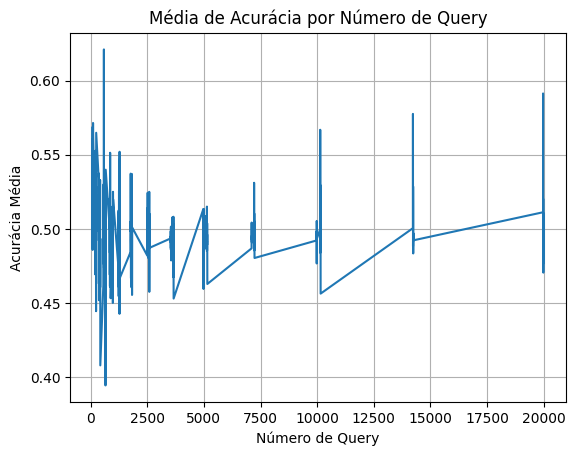

In [100]:
df_l2 = df[df['distance'] == 'l2']

# Agrupando por 'query_num' e calculando a média de 'acc'
df_grouped = df_l2.groupby('query_num')['acc'].mean().reset_index()

# Plotando o gráfico de linha
plt.plot(df_grouped['query_num'], df_grouped['acc'])
plt.title('Média de Acurácia por Número de Query')
plt.xlabel('Número de Query')
plt.ylabel('Acurácia Média')
plt.grid(True)
plt.show()

/var/folders/fs/f8qz96w55l1cqqbyb70x11380000gn/T/ipykernel_65100/1261788340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_l2['query_group'] = pd.cut(df_l2['query_num'], bins=intervalos)


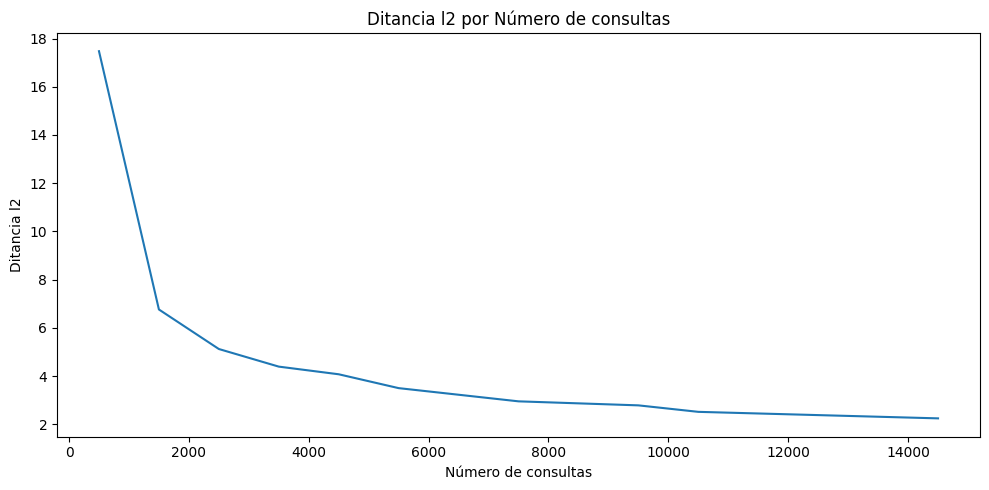

In [101]:
intervalos = range(0, int(max(df_l2['query_num'])), 1000)

# Criar uma nova coluna para os intervalos
df_l2['query_group'] = pd.cut(df_l2['query_num'], bins=intervalos)

# Agrupar por essa nova coluna e calcular a média de 'norm_p'
df_grouped = df_l2.groupby('query_group')['norm_p'].mean().reset_index()
df_grouped['query_group_mid'] = df_grouped['query_group'].apply(lambda x: x.mid).astype(float)

df_grouped = df_grouped.dropna(subset=['norm_p'])

# Agora plotando o gráfico
plt.figure(figsize=(10,5))
plt.plot(df_grouped['query_group_mid'], df_grouped['norm_p'])
plt.title('Ditancia l2 por Número de consultas')
plt.xlabel('Número de consultas')
plt.ylabel('Ditancia l2')
plt.tight_layout()  # Ajuste automático para caber bem no espaço disponível
plt.show()

/var/folders/fs/f8qz96w55l1cqqbyb70x11380000gn/T/ipykernel_65100/3713148607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_l2['query_group'] = pd.cut(df_l2['query_num'], bins=intervalos)


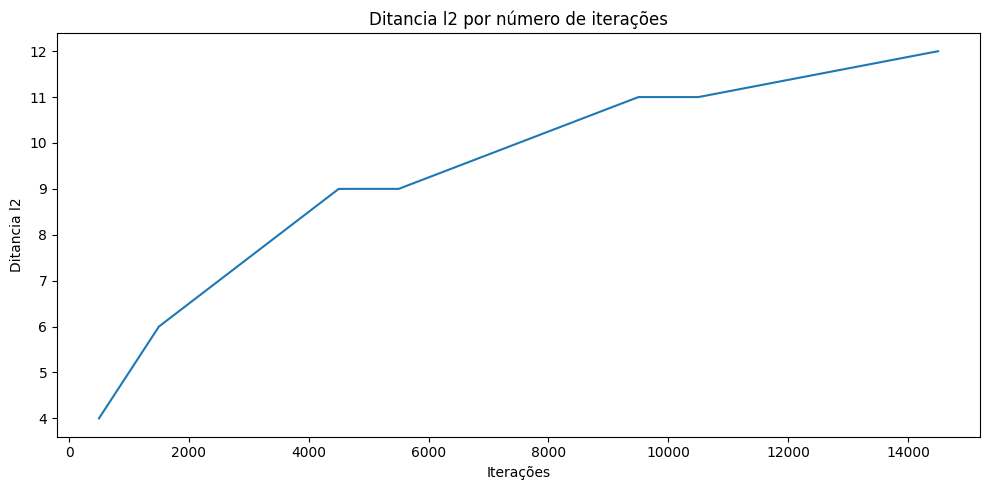

In [102]:
intervalos = range(0, int(max(df_l2['query_num'])), 1000)

# Criar uma nova coluna para os intervalos
df_l2['query_group'] = pd.cut(df_l2['query_num'], bins=intervalos)

# Agrupar por essa nova coluna e calcular a média de 'norm_p'
df_grouped = df_l2.groupby('query_group')['iteration'].max().reset_index()
df_grouped['query_group_mid'] = df_grouped['query_group'].apply(lambda x: x.mid).astype(float)


df_grouped = df_grouped.dropna(subset=['iteration'])

# Agora plotando o gráfico
plt.figure(figsize=(10,5))
plt.plot(df_grouped['query_group_mid'], df_grouped['iteration'])
plt.title('Ditancia l2 por número de iterações')
plt.xlabel('Iterações')
plt.ylabel('Ditancia l2')
plt.tight_layout()  # Ajuste automático para caber bem no espaço disponível
plt.show()